In [1]:
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown, Math

# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph, pinta_tikz, plot_cargas

# Enunciado
Considere la información del proyecto cuya información aparece en la tabla adjunta. Considere en cada apartado que el proyecto se encuentra en su situación inalterada mostrada en los datos del proyecto.

In [2]:
periodo_a_probabilidad = 17
periodo_b_probabilidad = 19
duracion_objetivo = 18
limite_maximo_recursos = 6
pregunta_1 = f"1. ¿Cuál es la probabilidad de terminar el proyecto entre {periodo_a_probabilidad} y {periodo_b_probabilidad} semanas?  "
pregunta_2 = f"2. Reduzca, con mínimo incremento de coste la duración media del proyecto a {duracion_objetivo} semanas. ¿Cuál será ahora la probabilidad de terminar en {duracion_objetivo} semanas? ¿Por qué?  "
pregunta_3 = f"3. ¿Se encuentran nivelados los recursos consumidos por el proyecto? De no ser así proceda a su nivelación.  "
pregunta_4 = f"4. Si su empresa sólo puede destinar a {limite_maximo_recursos} personas al proyecto, ¿se encuentran los recursos de mano de obra correctamente asignados? Reprográmelo si fuera necesario de modo que se cumpla esta restricción.  "

In [3]:
display(Markdown(pregunta_1))
display(Markdown(pregunta_2))
display(Markdown(pregunta_3))
display(Markdown(pregunta_4))

1. ¿Cuál es la probabilidad de terminar el proyecto entre 17 y 19 semanas?  

2. Reduzca, con mínimo incremento de coste la duración media del proyecto a 18 semanas. ¿Cuál será ahora la probabilidad de terminar en 18 semanas? ¿Por qué?  

3. ¿Se encuentran nivelados los recursos consumidos por el proyecto? De no ser así proceda a su nivelación.  

4. Si su empresa sólo puede destinar a 6 personas al proyecto, ¿se encuentran los recursos de mano de obra correctamente asignados? Reprográmelo si fuera necesario de modo que se cumpla esta restricción.  

In [4]:
#| tbl-cap: "Cuadro de datos del enunciado del ejercicio"
#| label: tbl-datosEnunciado
# Alargamos el ancho de las celdas al 100%
from IPython.display import display, HTML

import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, varianza,  cur,  recursos, duracion_tope
     ('A',       '---  ',      2,        1,     -100,     2,         1        ),
     ('B',       '---  ',      4,        1,       30,     4,         2        ),
     ('C',       'B    ',      1,        1,   np.inf,     2,         1        ),
     ('D',       'A    ',      3,        1,       50,     2,         1        ),
     ('E',       'B,D  ',      7,        1,       20,     2,         4        ),
     ('F',       'C    ',      4,        1,       10,     2,         2        ),
     ('G',       '---  ',      1,        2,      100,     4,         1        ),
     ('H',       'G    ',     11,        2,       10,     2,         8        ),
     ('I',       'E,F,H',      2,        1,       50,     2,         1        ),
     ('J',       'E,F,H',      8,        1,        5,     2,         7        ),
] ,columns=['activity', 'predecessor', 'duration', 'variance', 'ucr', 'resources', 'crash_duration']).set_index('activity')

datos_enunciado

,predecessor,duration,variance,ucr,resources,crash_duration
activity,,,,,,
A,---,2,1,-100.0,2,1
B,---,4,1,30.0,4,2
C,B,1,1,inf,2,1
D,A,3,1,50.0,2,1
E,"B,D",7,1,20.0,2,4
F,C,4,1,10.0,2,2
G,---,1,2,100.0,4,1
H,G,11,2,10.0,2,8
I,"E,F,H",2,1,50.0,2,1


# Solución
## Apartado 1

In [5]:
display(Markdown(pregunta_1))

1. ¿Cuál es la probabilidad de terminar el proyecto entre 17 y 19 semanas?  

### Cuadro de prelaciones

Comenzamos construyendo el cuadro de prelaciones. Este cuadro nos permitirá construir los grafos Pert o Roy, si atendemos a la información de las filas; o comprobar si el grafo obtenido es correcto, atendiendo a la información de las columnas.

In [6]:
#| tbl-cap: "Cuadro de prelaciones expandido"
#| label: tbl-prelaciones
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J
activities,,,,,,,,,,
A,,,,,,,,,,
B,,,,,,,,,,
C,,True,,,,,,,,
D,True,,,,,,,,,
E,,True,,True,,,,,,
F,,,True,,,,,,,
G,,,,,,,,,,
H,,,,,,,True,,,
I,,,,,True,True,,True,,


In [7]:
proyecto = prelaciones.create_project()

### Grafo PERT con numeración de nodos

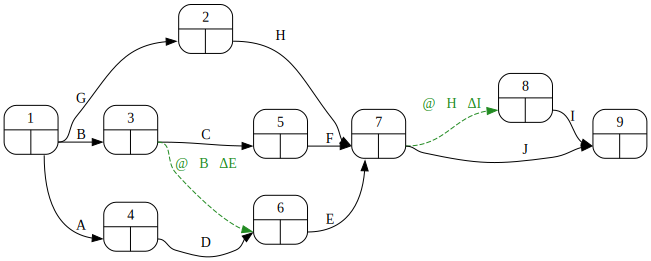

In [8]:
#| fig-cap: "Grafo Pert con indicación de los números de nodos"
#| label: fig-pertNumeracionNodos
proyecto.pert()

### Matriz de Zaderenko

In [9]:
#| tbl-cap: "Matriz de Zaderenko para el cálculo de tiempos tempranos y tardíos"
#| label: tbl-Zaderenko
proyecto.zaderenko(durations=datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,early
1,,1.0,4.0,2.0,,,,,,0.0
2,,,,,,,11.0,,,1.0
3,,,,,1.0,0.0,,,,4.0
4,,,,,,3.0,,,,2.0
5,,,,,,,4.0,,,5.0
6,,,,,,,7.0,,,5.0
7,,,,,,,,0.0,8.0,12.0
8,,,,,,,,,2.0,12.0
9,,,,,,,,,,20.0
late,0.0,1.0,5.0,2.0,8.0,5.0,12.0,18.0,20.0,


Los tiempos tempranos y tardios han resultado ser:

In [10]:
#| tbl-cap: "Valores de los tiempos tempranos y tardíos de los nodos"
#| label: tbl-TempranosTardios
resultados_pert = proyecto.calculate_pert(durations=datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,1,1
3,4,5
4,2,2
5,5,8
6,5,5
7,12,12
8,12,18
9,20,20


### Duración media del proyecto

La duración media del proyecto es:

In [11]:
duracion_media_proyecto = int(proyecto.duration(durations=datos_proyecto['duration']))
Markdown(f"La información del nodo final del proyecto nos informa de la duración media del proyecto: {duracion_media_proyecto} periodos")

La información del nodo final del proyecto nos informa de la duración media del proyecto: 20 periodos

### Holgura total de las actividades
A partir de los tiempos tempranos y tardíos, y de las duraciones de las actividades, podemos determinar la holgura total de las actividades y con ellas las rutas del camino crítico.

In [12]:
#| tbl-cap: "Valor de la holgura total de las actividades"
#| label: tbl-htotal
resultados_pert['activities']

,H_total
@∇B⤑ΔE,1
@∇H⤑ΔI,6
A,0
B,1
C,3
D,0
E,0
F,3
G,0
H,0


### Camino crítico

El camino crítico consta de las siguientes rutas:

In [13]:
proyecto.display_critical_path(durations=datos_proyecto['duration'])

- Route_2 :	A, D, E, J <br> 

- Route_8 :	G, H, J <br> 

### Calendario del proyecto
Se muestra a continuación el calendario del proyecto, con indicación de las fechas de inicio y fin más tempranas y tardías de cada actividad:

In [14]:
#| tbl-cap: "Calendario del proyecto"
#| label: tbl-calendario
calendario = proyecto.calendar(datos_proyecto['duration'])
calendario

,inicio_mas_temprano,inicio_mas_tardio,fin_mas_temprano,fin_mas_tardio,H_total,duracion
activity,,,,,,
A,0,0,2,2,0,2
B,0,1,4,5,1,4
C,4,7,5,8,3,1
D,2,2,5,5,0,3
E,5,5,12,12,0,7
F,5,8,9,12,3,4
G,0,0,1,1,0,1
H,1,1,12,12,0,11
I,12,18,14,20,6,2


### Grafo PERT con indicación de tiempos y rutas del camino crítico de acuerdo a la planificación inicial
A continuación se muestra el grafo Pert del proyecto, con indicación de las actividades críticas:

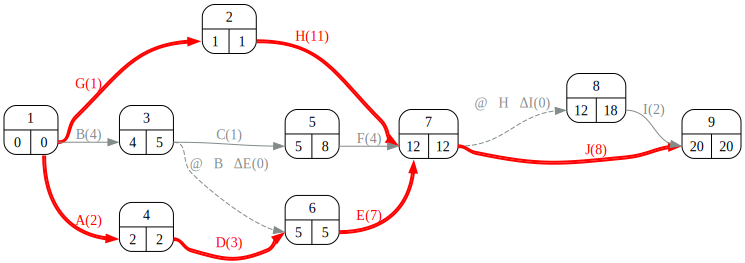

In [15]:
#| fig-cap: "Grafo Pert con indicación del camino crítico"
#| label: fig-pertrutasCriticas
proyecto.pert(durations=datos_proyecto['duration'])

### Caracterización de la duración del proyecto mediante una distribución Normal
A fin de calcular la probabilidad pedida, es necesario caracterizar la distribución Normal de la duración del proyecto. Esto consiste en determinar los valores de sus parámetros: media y desviación típica de la duración del proyecto.

In [16]:
duracion_media_proyecto = int(proyecto.duration(datos_proyecto['duration']))
Markdown(f"La duración media del proyecto ya la tenemos calculada: {duracion_media_proyecto} periodos")

La duración media del proyecto ya la tenemos calculada: 20 periodos

Para determinar la desviación típica debemos obtener en cada rama del camino crítico la suma de las varianzas, y quedarnos con la mayor.

In [17]:
desviacion_proyecto, varianza_rutas = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto['variance'])

In [18]:
#| tbl-cap: "Varianza de las rutas del camino crítico"
#| label: tbl-varianzaRutas
varianza_rutas

,Activities,Variance
Route_2,"A, D, E, J",4.00
Route_8,"G, H, J",5.00


In [19]:
Markdown(f"El proyecto sigue una distribución normal con media {duracion_media_proyecto} periodos y desviación típica {round(desviacion_proyecto, 2)}.")

El proyecto sigue una distribución normal con media 20 periodos y desviación típica 2.24.

### Probabilidad de terminar entre 17 y 19 periodos

In [20]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_b = round(norm.cdf(periodo_b_probabilidad, loc=duracion_media_proyecto, scale=desviacion_proyecto), 2)
probabilidad_de_terminar_antes_de_a = round(norm.cdf(periodo_a_probabilidad, loc=duracion_media_proyecto, scale=desviacion_proyecto), 2)

probabilidad_de_terminar_entre_a_y_b = probabilidad_de_terminar_antes_de_b - probabilidad_de_terminar_antes_de_a

In [21]:
Markdown(f"""Una vez caracterizada la distribución normal con la que aproximamos la duración del proyecto, podemos hacer el cálculo de la probabilidad de terminar entre los periodos {periodo_a_probabilidad} y {periodo_b_probabilidad}.  
- La probabilidad de terminar antes de {periodo_a_probabilidad} periodos es  {probabilidad_de_terminar_antes_de_a}  
- La probabilidad de terminar antes de {periodo_b_probabilidad} periodos es {probabilidad_de_terminar_antes_de_b}  

Por tanto, a partir de la diferencia de estos dos valores tenemos la probabilidad de terminar dentro del mencionado intervalo: {int(probabilidad_de_terminar_entre_a_y_b*100)} por ciento.
""")

Una vez caracterizada la distribución normal con la que aproximamos la duración del proyecto, podemos hacer el cálculo de la probabilidad de terminar entre los periodos 17 y 19.  
- La probabilidad de terminar antes de 17 periodos es  0.09  
- La probabilidad de terminar antes de 19 periodos es 0.33  

Por tanto, a partir de la diferencia de estos dos valores tenemos la probabilidad de terminar dentro del mencionado intervalo: 24 por ciento.


## Apartado 2

In [22]:
display(Markdown(pregunta_2))

2. Reduzca, con mínimo incremento de coste la duración media del proyecto a 18 semanas. ¿Cuál será ahora la probabilidad de terminar en 18 semanas? ¿Por qué?  

### Reducción a la duración objetivo con mínimo incremento de coste

In [23]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                min_durations=datos_proyecto['crash_duration'],
                costs=datos_proyecto['ucr'],
                reduction=2)

In [24]:
#| tbl-cap: "Cuadro del algoritmo de Ackoff Sasieni"
#| label: tbl-ackoffƒ
ackoff

,A,B,C,D,E,F,G,H,I,J,0,1,2
Route_1,-100.0,,,50.0,20.0,,,,50.0,,14.0,13.0,13.0
Route_2,-100.0,,,50.0,20.0,,,,,5.0,20.0,18.0,18.0
Route_3,,30.0,inf,,,10.0,,,50.0,,11.0,11.0,11.0
Route_4,,30.0,inf,,,10.0,,,,5.0,17.0,16.0,16.0
Route_5,,30.0,,,20.0,,,,50.0,,13.0,13.0,13.0
Route_6,,30.0,,,20.0,,,,,5.0,19.0,18.0,18.0
Route_7,,,,,,,100.0,10.0,50.0,,14.0,14.0,13.0
Route_8,,,,,,,100.0,10.0,,5.0,20.0,19.0,18.0
0,1.0,2.0,0.0,2.0,3.0,2.0,0.0,3.0,1.0,1.0,,,
1,0.0,2.0,0.0,2.0,3.0,2.0,0.0,3.0,1.0,0.0,,,


### Probabilidad de terminar antes de 18 periodos
Al ser 18 el valor de la media de la duración, la probabilidad pedida es del 50%.

## Apartado 3

In [25]:
display(Markdown(pregunta_3))

3. ¿Se encuentran nivelados los recursos consumidos por el proyecto? De no ser así proceda a su nivelación.  

### Análisis de la situación inicial

Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

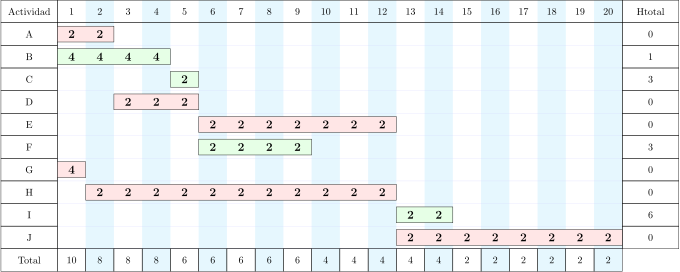

In [26]:
#| fig-cap: "Distribución inicial del consumo de recursos"
#| label: fig-recursosInicial
proyecto_nivelacion = proyecto.copy()
duration_resources = datos_enunciado[['duration','resources']].copy()
gantt_df, dibujo = proyecto_nivelacion.gantt(data=duration_resources,
                          duration_label='duration',
                          resource_label='resources',
                          holguras=True,
                          total='fila', 
                          tikz=True)
pinta_tikz(dibujo)

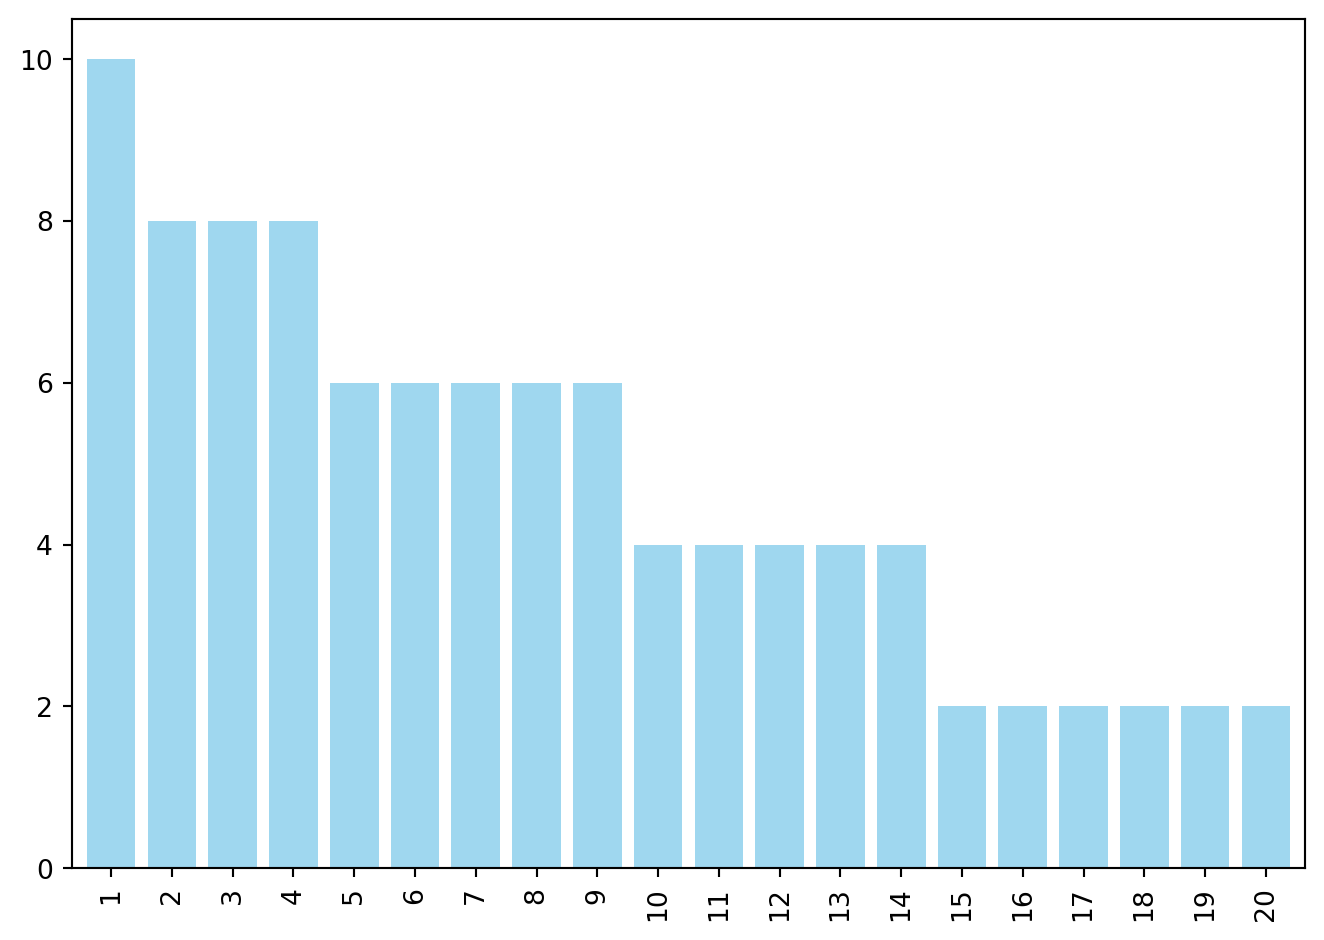

In [27]:
#| fig-cap: "Diagrama de cargas del proyecto de acuerdo a su planificación inicial"
#| label: fig-preNivelaciónBarras
plot_cargas(gantt_df=gantt_df, limite_maximo_recursos=None)

La demanda de recursos actual no se encuentra nivelada. Se procede a aplicar el algoritmo de nivelación.

### Nivelación de los recursos

In [28]:
desplazamientos, cuadrados, my_data, gantt_df, dibujo = proyecto_nivelacion.nivelar(data=datos_proyecto,
                           duration_label='duration',
                           resource_label='resources',
                           report=False
                           )

Se procede a valorar los posibles desplazamientos de cada actividad no crítica, considerando estas en el orden correspondiente a su fecha de finalización, de más pronto a más tarde. El siguiente cuadro muestra el valor de la suma de cuadrados de las cargas para cada actividad, en filas según el mencionado orden, y posible desplazamiento, en columnas.

In [29]:
#| tbl-cap: "Cuadro del suma de cuadrados de las cargas para cada actividad y desplazamiento"
#| label: tbl-sumaCuadrados
cuadrados

,0,1,2,3,4,5,6
activity,,,,,,,
B,576,560,,,,,
C,560,560,560,,,,
F,560,560,560,,,,
I,560,560,560,560,560,560,560


El resultado de estos desplazamientos se muestra en la siguiente figura.

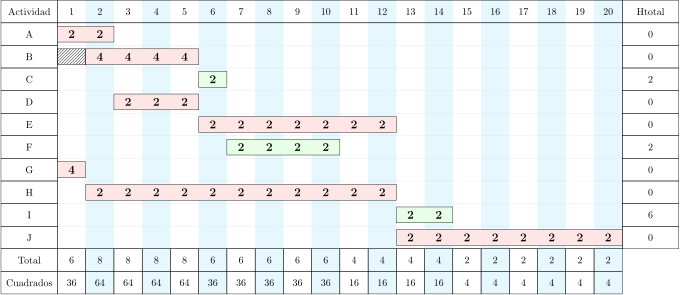

In [30]:
#| fig-cap: "Resultado de aplicar el algoritmo de nivelación al proyecto"
#| label: fig-GanttTrasNivelacion
pinta_tikz(dibujo)

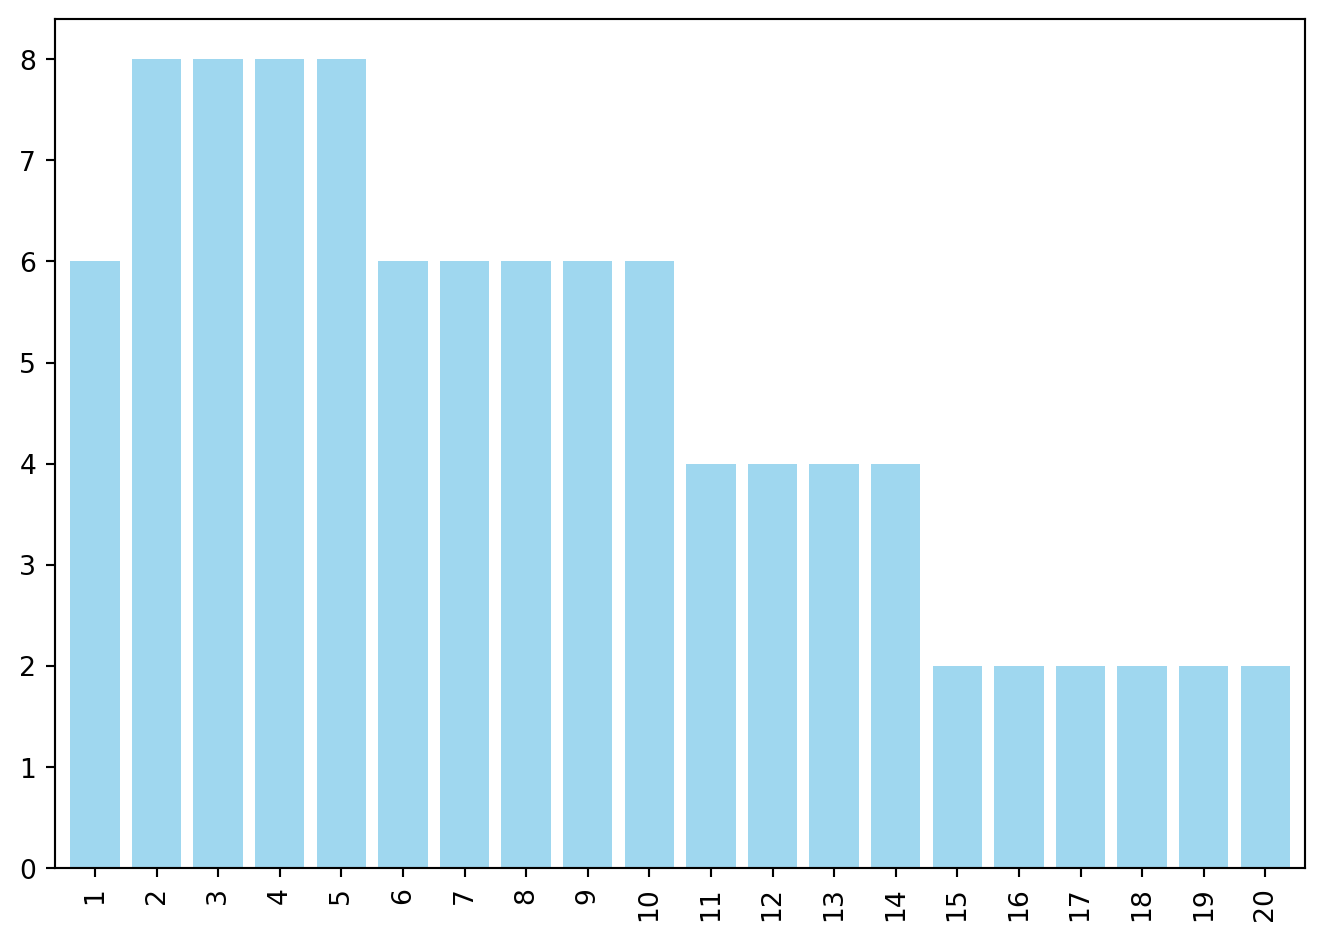

In [31]:
#| fig-cap: "Diagrama de cargas del proyecto tras aplicar el algoritmo de nivelación"
#| label: fig-postNivelaciónBarras
plot_cargas(gantt_df=gantt_df, limite_maximo_recursos=None)

## Apartado 4

In [32]:
display(Markdown(pregunta_4))

4. Si su empresa sólo puede destinar a 6 personas al proyecto, ¿se encuentran los recursos de mano de obra correctamente asignados? Reprográmelo si fuera necesario de modo que se cumpla esta restricción.  

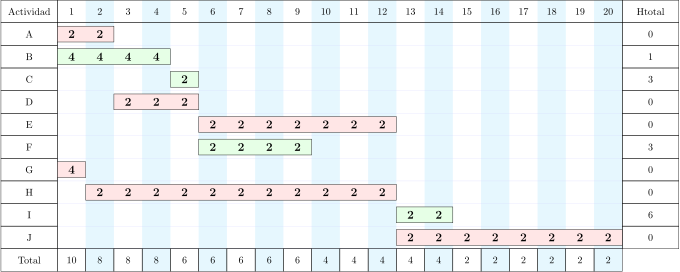

In [33]:
proyecto_asignacion = proyecto_nivelacion.copy()
duration_resources = datos_enunciado[['duration','resources']].copy()
gantt_df, dibujo = proyecto_asignacion.gantt(duration_resources, 'duration', 'resources', total='fila', holguras=True, tikz=True)
pinta_tikz(dibujo)

La fila "Total" obtenida, que podemos representar gráficamente en la siguiente figura, proporciona la información del consumo previsto de recursos a lo largo del tiempo y el valor límite establecido (línea horizontal discontinua).

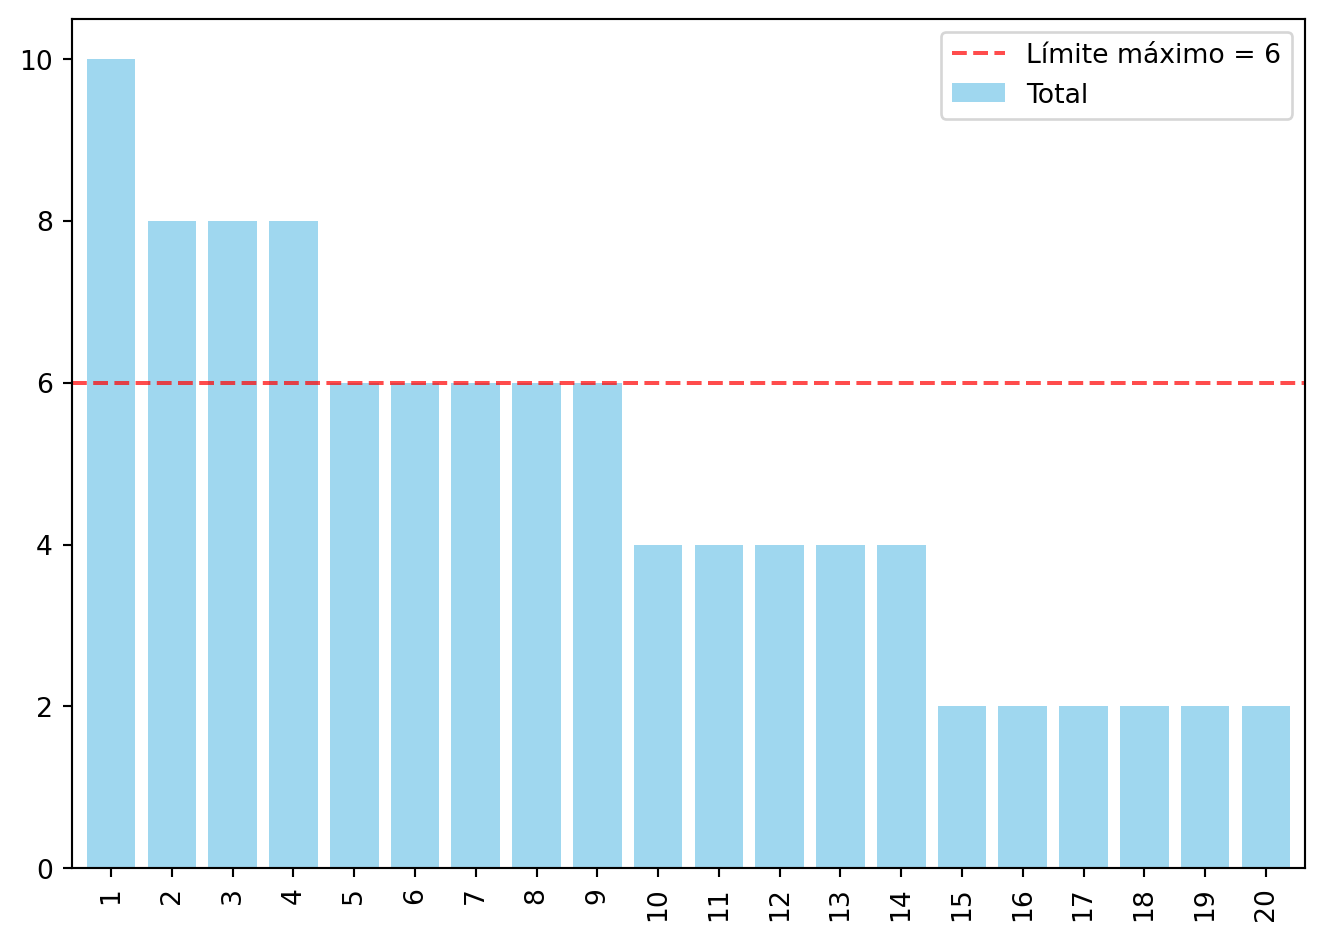

In [34]:
#| fig-cap: "Diagrama de cargas antes de aplicar el algoritmo de asignación"
#| label: fig-preAsignacionBarras
plot_cargas(gantt_df, limite_maximo_recursos)

In [35]:
Markdown(f"El proyecto requiere en algunos periodos más de {limite_maximo_recursos} personas. Es necesario aplicar el algorimo de asignación, según se muestra en la siguiente figura.")

El proyecto requiere en algunos periodos más de 6 personas. Es necesario aplicar el algorimo de asignación, según se muestra en la siguiente figura.

In [36]:
duracion_y_recursos = datos_proyecto[['duration', 'resources']]
my_data, gantt_df, dibujo  = proyecto_asignacion.asignar(
                                    data=duracion_y_recursos,
                                    duration_label='duration',
                                    resource_label='resources',
                                    maximo=[limite_maximo_recursos],
                                    report=False
                                    )

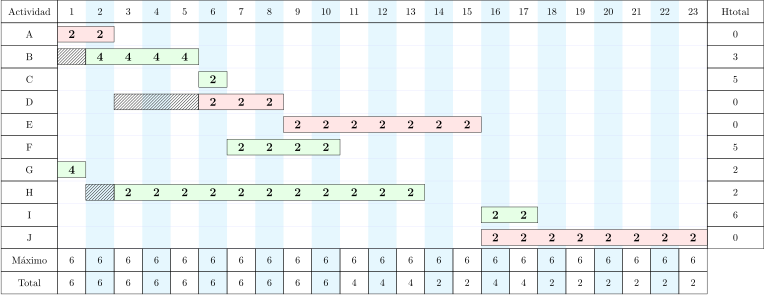

In [37]:
#| fig-cap: "Diagrama de Gantt del proyecto tras la asignación"
#| label: fig-ganttPostAsignación
pinta_tikz(dibujo)

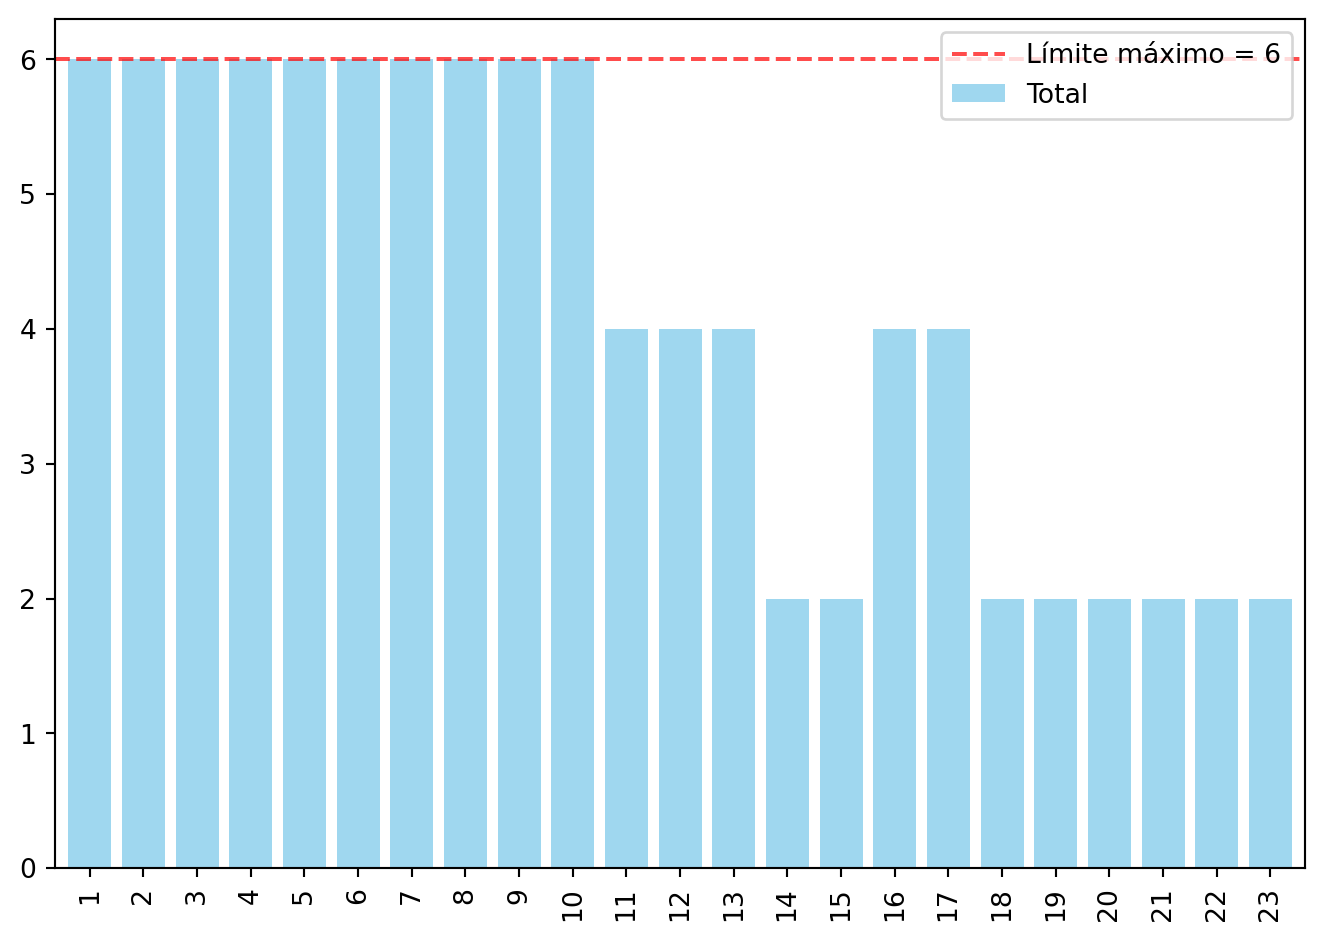

In [38]:
#| fig-cap: "Diagrama de cargas tras aplicar el algoritmo de asignación"
#| label: fig-postAsignacionBarras
plot_cargas(gantt_df, limite_maximo_recursos)

Tras aplicar el algoritmo de asignación el proyecto es compatible con los límites establecidos.